# Camera Calibration Example

## Generate data

In [1]:
%cd ..

/mnt/d/CodingProjects/zodiacal-polarized


In [2]:
import astropy.units as u
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import os
from astropy.time import Time
from scipy.optimize import least_squares

from zodipol.utils.math import normalize
from zodipol.mie_scattering.mie_scattering_model import MieScatteringModel
from zodipy_local.zodipy_local import Zodipy
from zodipol.imager.imager import Imager
from zodipol.background_radiation.integrated_starlight import IntegratedStarlight
from scripts.create_image_example import generate_spectrum
from scripts.camera_calibration_example import make_camera_images

In [3]:
def make_image_mask(theta, phi, nside, radius):
    center_vec = hp.ang2vec(theta, phi)
    disc_values = hp.query_disc(nside=nside, vec=center_vec, radius=np.deg2rad(radius), inclusive=True, fact=4, nest=False)
    mask = np.full((hp.nside2npix(nside),), False)
    mask[disc_values] = True
    return mask, disc_values

In [4]:
nside = 64  # Healpix resolution
fov = 5  # deg
n_polarization_dims = 8
polarization_angle_org = np.linspace(0, np.pi, n_polarization_dims, endpoint=False)  # Polarization angle of the observation
polarization_angle_diff = np.diff(polarization_angle_org).mean()

In [5]:
imager = Imager()
model = Zodipy("dirbe", solar_cut=30 * u.deg, extrapolate=True, parallel=True)  # Initialize the model

In [6]:
wavelength, frequency, imager_response = generate_spectrum(imager, n_freq=20)
frequency_weight = np.ones_like(frequency)  # Weight of the frequencies

In [7]:
mie_model_path = 'saved_models/white_light_mie_model.npz'
if os.path.isfile(mie_model_path):
    mie_model = MieScatteringModel.load(mie_model_path)
else:
    spectrum = np.logspace(np.log10(300), np.log10(700), 20)  # white light wavelength in nm
    mie_model = MieScatteringModel.train(spectrum)

In [8]:
integrated_starlight_path = 'saved_models/skymap_flux.npz'
if os.path.isfile(integrated_starlight_path):
    isl = IntegratedStarlight.load(integrated_starlight_path)
    isl.resize_skymap(nside, update=True)
    isl.interpolate_freq(frequency.to('Hz'), update=True)

    df, dw = np.gradient(frequency), -np.gradient(wavelength)
    isl_map = isl.isl_map * (dw / df)[None, ...]
else:
    isl_map = 0

In [9]:
binned_emission = model.get_binned_emission_pix(
    frequency,
    weights=frequency_weight,
    pixels=np.arange(hp.nside2npix(nside)),
    nside=nside,
    obs_time=Time("2022-06-14"),
    obs="earth",
    mie_scattering_model=mie_model,
    return_IQU=True
)
binned_emission = np.nan_to_num(binned_emission, nan=0)
I, U, Q = binned_emission[..., 0], binned_emission[..., 1], binned_emission[..., 2]
I = I + isl_map

2023-02-21 22:23:12,854 - INFO - Started pixels unit vector calculations
2023-02-21 22:23:12,860 - INFO - Started emission calculations
2023-02-21 22:23:12,861 - INFO - Started model parameters calculations
2023-02-21 22:23:12,865 - INFO - Started observer position calculations
2023-02-21 22:23:12,888 - INFO - Started line of sight calculations
2023-02-21 22:23:12,910 - INFO - Started density partials calculations
/mnt/d/CodingProjects/zodiacal-polarized/zodipol/zodipy_local/zodipy_local/_source_funcs.py:28: RuntimeWarning: overflow encountered in expm1
  term2 = np.expm1((h * freq) / (k_B * T))
2023-02-21 22:23:12,929 - INFO - Started common integrand calculations
2023-02-21 22:23:12,930 - INFO - Started parallel emission calculations
2023-02-21 22:24:29,878 - INFO - Started emission binning
2023-02-21 22:24:30,067 - INFO - Started polarization calculations


## Camera polarizer angler calibration

### Full field of view

In [13]:
polarizance = 1  # Polarizance of the observation

polarization_shift_list = np.linspace(0, np.pi, 10)
calibration_results = []
for polarization_shift in polarization_shift_list:
    polarization_angle = polarization_shift + polarization_angle_org  # Polarization angle of the observation
    df_ind = polarization_angle_diff * np.arange(n_polarization_dims)
    make_img = lambda eta: make_camera_images(I, U, Q, polarizance, eta+df_ind, imager, model, frequency, imager_response, add_noise=False)

    polarization_angle_res = []
    for ii in range(10):
        camera_intensity_real = make_camera_images(I, U, Q, polarizance, polarization_angle, imager, model, frequency, imager_response)
        cost_function = lambda eta: 1e23 * (make_img(eta) - camera_intensity_real).value.flatten()
        res = least_squares(cost_function, x0=0, bounds=(-np.pi/2, np.pi/2))
        polarization_angle_res.append(res.x)
    calibration_results.append(np.array(polarization_angle_res))
    print(f"Estimated polarization angle for eta={polarization_shift:.2f}: {np.mean(polarization_angle_res)%np.pi:.2f} +/- {np.std(polarization_angle_res):.2f} rad")
calibration_results = np.array(calibration_results).squeeze()

Estimated polarization angle for eta=0.00: 0.00 +/- 0.00 rad
Estimated polarization angle for eta=0.35: 0.35 +/- 0.00 rad
Estimated polarization angle for eta=0.70: 0.70 +/- 0.00 rad
Estimated polarization angle for eta=1.05: 1.05 +/- 0.00 rad
Estimated polarization angle for eta=1.40: 1.40 +/- 0.00 rad
Estimated polarization angle for eta=1.75: 1.75 +/- 0.00 rad
Estimated polarization angle for eta=2.09: 2.09 +/- 0.00 rad
Estimated polarization angle for eta=2.44: 2.44 +/- 0.00 rad
Estimated polarization angle for eta=2.79: 2.79 +/- 0.00 rad
Estimated polarization angle for eta=3.14: 3.14 +/- 0.00 rad


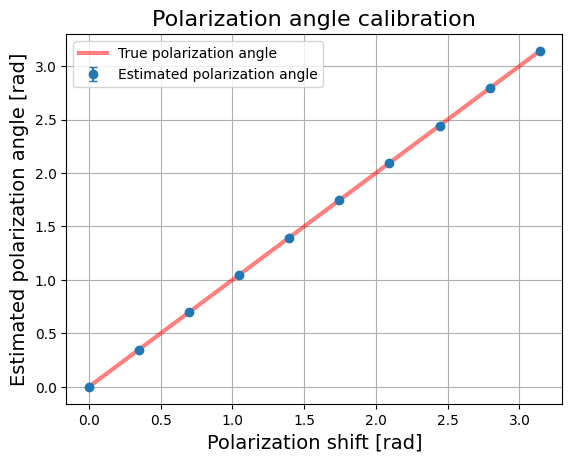

In [14]:
calib_mean = np.unwrap(calibration_results.mean(axis=1), period=np.pi)
calib_std = calibration_results.std(axis=1)

plt.figure()
plt.errorbar(polarization_shift_list, calib_mean, yerr=calib_std, fmt='o', capsize=3, label="Estimated polarization angle")
plt.plot(polarization_shift_list, polarization_shift_list, c='r', alpha=0.5, lw=3, label="True polarization angle")
plt.xlabel("Polarization shift [rad]", fontsize=14)
plt.ylabel("Estimated polarization angle [rad]", fontsize=14)
plt.title("Polarization angle calibration", fontsize=16)
plt.grid()
plt.legend()
plt.show()

### Small field of view

In [15]:
polarizance = 1  # Polarizance of the observation

mask, mask_ind = make_image_mask(np.pi/2, 0, nside, fov)
polarization_shift_list = np.linspace(0, np.pi, 10)
calibration_results = []
for polarization_shift in polarization_shift_list:
    polarization_angle = polarization_shift + polarization_angle_org  # Polarization angle of the observation
    df_ind = polarization_angle_diff * np.arange(n_polarization_dims)
    make_img = lambda eta: make_camera_images(I, U, Q, polarizance, eta+df_ind, imager, model, frequency, imager_response, add_noise=False)[mask_ind, ...]

    polarization_angle_res = []
    for ii in range(10):
        camera_intensity_real = make_camera_images(I, U, Q, polarizance, polarization_angle, imager, model, frequency, imager_response)[mask_ind, ...]
        cost_function = lambda eta: 1e23 * (make_img(eta) - camera_intensity_real).value.flatten()
        res = least_squares(cost_function, x0=0, bounds=(-np.pi/2, np.pi/2))
        polarization_angle_res.append(res.x)
    calibration_results.append(np.array(polarization_angle_res))
    print(f"Estimated polarization angle for eta={polarization_shift:.2f}: {np.mean(polarization_angle_res):.2f} +/- {np.std(polarization_angle_res):.2f} rad")
calibration_results = np.array(calibration_results).squeeze()

Estimated polarization angle for eta=0.00: 0.00 +/- 0.00 rad
Estimated polarization angle for eta=0.35: 0.35 +/- 0.00 rad
Estimated polarization angle for eta=0.70: 0.70 +/- 0.00 rad
Estimated polarization angle for eta=1.05: 1.05 +/- 0.01 rad
Estimated polarization angle for eta=1.40: 1.40 +/- 0.00 rad
Estimated polarization angle for eta=1.75: -1.40 +/- 0.01 rad
Estimated polarization angle for eta=2.09: -1.05 +/- 0.00 rad
Estimated polarization angle for eta=2.44: -0.70 +/- 0.01 rad
Estimated polarization angle for eta=2.79: -0.35 +/- 0.00 rad
Estimated polarization angle for eta=3.14: -0.00 +/- 0.00 rad


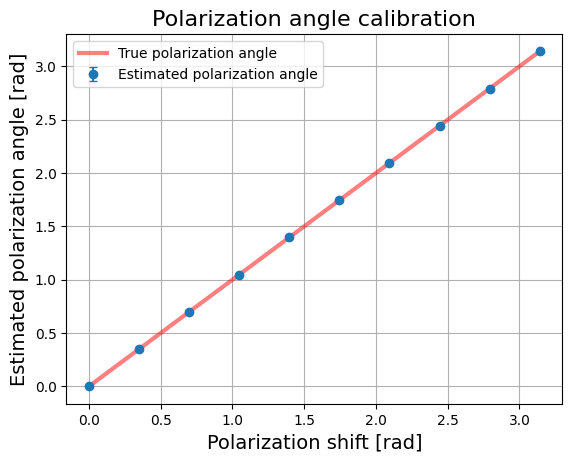

In [16]:
calib_mean = np.unwrap(calibration_results.mean(axis=1), period=np.pi)
calib_std = calibration_results.std(axis=1)

plt.figure()
plt.errorbar(polarization_shift_list, calib_mean, yerr=calib_std, fmt='o', capsize=3, label="Estimated polarization angle")
plt.plot(polarization_shift_list, polarization_shift_list, c='r', alpha=0.5, lw=3, label="True polarization angle")
plt.xlabel("Polarization shift [rad]", fontsize=14)
plt.ylabel("Estimated polarization angle [rad]", fontsize=14)
plt.title("Polarization angle calibration", fontsize=16)
plt.grid()
plt.legend()
plt.show()

## Camera polarizance calibration

### Full field of view

In [10]:
polarization_angle = polarization_angle_org  # Polarization angle of the observation

In [11]:
polarizance_list = np.linspace(0.5, 1, 10)  # Polarizance of the observation
calibration_results = []
for polarizance in polarizance_list:
    df_ind = polarization_angle_diff * np.arange(n_polarization_dims)
    make_img = lambda p: make_camera_images(I, U, Q, p, df_ind, imager, model, frequency, imager_response, add_noise=False)

    polarization_angle_res = []
    for ii in range(10):
        camera_intensity_real = make_camera_images(I, U, Q, polarizance, polarization_angle, imager, model, frequency, imager_response)
        cost_function = lambda p: 1e23*(make_img(p) - camera_intensity_real).value.flatten()
        res = least_squares(cost_function, x0=0.5, bounds=(0, 1), diff_step=10)
        polarization_angle_res.append(res.x)
    calibration_results.append(np.array(polarization_angle_res))
    print(f"Estimated Polarizance for P={polarizance:.2f}: {np.mean(polarization_angle_res):.2f} +/- {np.std(polarization_angle_res):.2f}")
calibration_results = np.array(calibration_results).squeeze()

Estimated Polarizance for P=0.50: 0.50 +/- 0.00
Estimated Polarizance for P=0.56: 0.56 +/- 0.00
Estimated Polarizance for P=0.61: 0.61 +/- 0.00
Estimated Polarizance for P=0.67: 0.67 +/- 0.00
Estimated Polarizance for P=0.72: 0.72 +/- 0.00
Estimated Polarizance for P=0.78: 0.78 +/- 0.00
Estimated Polarizance for P=0.83: 0.83 +/- 0.00
Estimated Polarizance for P=0.89: 0.89 +/- 0.00
Estimated Polarizance for P=0.94: 0.94 +/- 0.00
Estimated Polarizance for P=1.00: 1.00 +/- 0.00


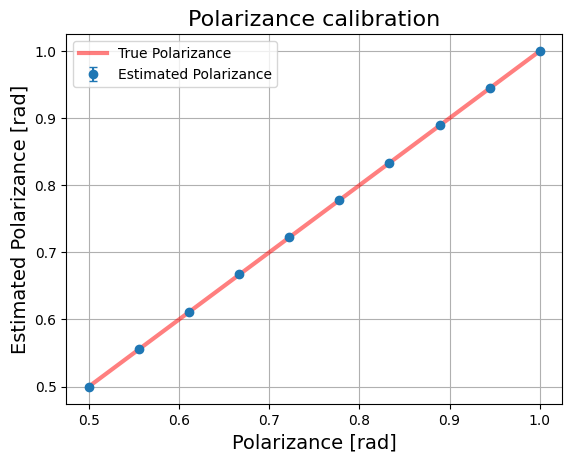

In [12]:
calib_mean = calibration_results.mean(axis=1)
calib_std = calibration_results.std(axis=1)

plt.figure()
plt.errorbar(polarizance_list, calib_mean, yerr=calib_std, fmt='o', capsize=3, label="Estimated Polarizance")
plt.plot(polarizance_list, polarizance_list, c='r', alpha=0.5, lw=3, label="True Polarizance")
plt.xlabel("Polarizance [rad]", fontsize=14)
plt.ylabel("Estimated Polarizance [rad]", fontsize=14)
plt.title("Polarizance calibration", fontsize=16)
plt.grid()
plt.legend()
plt.show()

### Small field of view

In [17]:
polarization_angle = polarization_angle_org  # Polarization angle of the observation

In [18]:
polarizance_list = np.linspace(0.5, 1, 10)  # Polarizance of the observation
mask, mask_ind = make_image_mask(np.pi/2, 0, nside, fov)
calibration_results = []
for polarizance in polarizance_list:
    df_ind = polarization_angle_diff * np.arange(n_polarization_dims)
    make_img = lambda p: make_camera_images(I, U, Q, p, df_ind, imager, model, frequency, imager_response, add_noise=False)[mask_ind, ...]

    polarization_angle_res = []
    for ii in range(10):
        camera_intensity_real = make_camera_images(I, U, Q, polarizance, polarization_angle, imager, model, frequency, imager_response)[mask_ind, ...]
        cost_function = lambda p: 1e23*(make_img(p) - camera_intensity_real).value.flatten()
        res = least_squares(cost_function, x0=0.5, bounds=(0, 1), diff_step=10)
        polarization_angle_res.append(res.x)
    calibration_results.append(np.array(polarization_angle_res))
    print(f"Estimated Polarizance for P={polarizance:.2f}: {np.mean(polarization_angle_res):.2f} +/- {np.std(polarization_angle_res):.2f}")
calibration_results = np.array(calibration_results).squeeze()

Estimated Polarizance for P=0.50: 0.50 +/- 0.01
Estimated Polarizance for P=0.56: 0.56 +/- 0.00
Estimated Polarizance for P=0.61: 0.61 +/- 0.01
Estimated Polarizance for P=0.67: 0.67 +/- 0.01
Estimated Polarizance for P=0.72: 0.72 +/- 0.01
Estimated Polarizance for P=0.78: 0.78 +/- 0.01
Estimated Polarizance for P=0.83: 0.83 +/- 0.01
Estimated Polarizance for P=0.89: 0.89 +/- 0.01
Estimated Polarizance for P=0.94: 0.94 +/- 0.01
Estimated Polarizance for P=1.00: 1.00 +/- 0.01


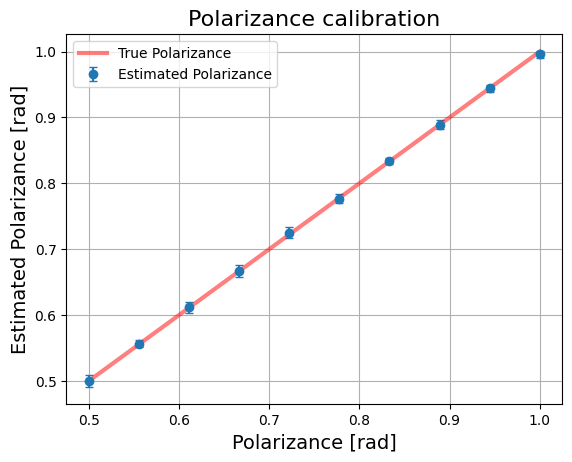

In [19]:
calib_mean = calibration_results.mean(axis=1)
calib_std = calibration_results.std(axis=1)

plt.figure()
plt.errorbar(polarizance_list, calib_mean, yerr=calib_std, fmt='o', capsize=3, label="Estimated Polarizance")
plt.plot(polarizance_list, polarizance_list, c='r', alpha=0.5, lw=3, label="True Polarizance")
plt.xlabel("Polarizance [rad]", fontsize=14)
plt.ylabel("Estimated Polarizance [rad]", fontsize=14)
plt.title("Polarizance calibration", fontsize=16)
plt.grid()
plt.legend()
plt.show()